In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
data = pd.read_csv("./prepared/yields_weather.csv")
n_munis = data["Municipality"].nunique(dropna=True)
print(f"- number of different municipalities: {n_munis}")
data.head()

- number of different municipalities: 83


,Municipality,Year,YieldPortfolio,Tmin_mean,Tmin_min,Tmax_mean,Tmax_max,Tmean_mean,Ptot_sum,Ptot_max,GDD_sum,HotDays_sum,FrostDays_sum,WetDays_sum
0,ALEXANDER,1996,0.381934,-2.231028,-37.795774,5.486426,34.526901,1.627699,0.777780,0.047799,1786.386633,5,189,112
1,ALEXANDER,1997,0.359387,-0.277886,-32.508271,7.448730,31.534680,3.585422,0.745016,0.035828,1811.883024,2,186,107
2,ALEXANDER,1998,0.365427,1.876897,-28.898511,9.551834,30.971862,5.714365,0.673300,0.040896,2024.970220,3,153,111
3,ALEXANDER,1999,0.415961,1.274463,-30.357541,8.904040,33.457402,5.089251,0.655147,0.035641,1822.989375,5,165,119
4,ALEXANDER,2000,0.279473,0.006244,-30.738687,7.698553,30.337081,3.852398,0.888865,0.043473,1813.705321,2,161,125


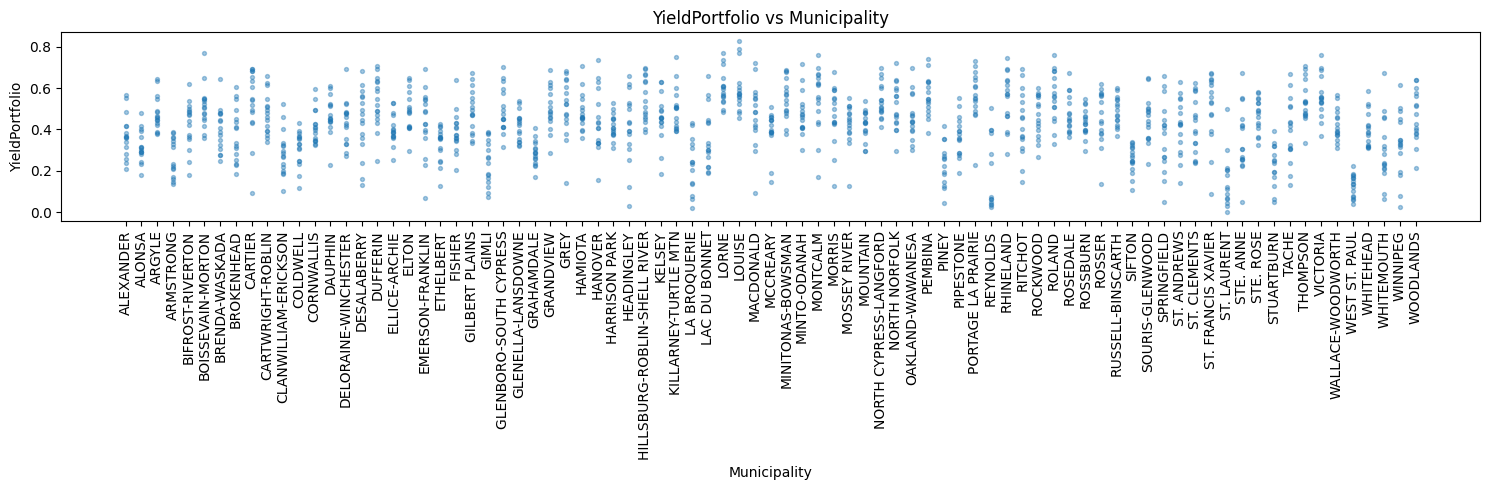

In [3]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data["Municipality"], data["YieldPortfolio"], s=8, alpha=0.4)
ax.tick_params(axis='x', labelrotation=90)
plt.xlabel("Municipality"); plt.ylabel("YieldPortfolio")
plt.title("YieldPortfolio vs Municipality")
plt.tight_layout()
plt.show()

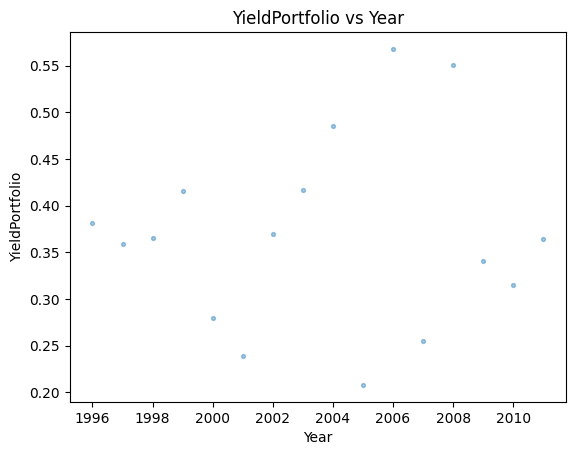

In [4]:
# yild/acre vs year visualization
df_m = data[data["Municipality"]=="ALEXANDER"]
plt.scatter(df_m["Year"], df_m["YieldPortfolio"], s=8, alpha=0.4)
plt.xlabel("Year"); plt.ylabel("YieldPortfolio")
plt.title("YieldPortfolio vs Year")
plt.show()

In [5]:
TESTINGYEARS = list(range(2008, 2012))
TRAININGYEARS = list(range(1996, 2008))

m = data[data["Municipality"]=="ALEXANDER"]
print(m.shape)
m_train = m[m["Year"].between(1996,2008)]
m_test = m[m["Year"].between(2008,2011)]
print(m_train.shape)
print(m_test.shape)

def ols(data, municipalitys=[], training_years=TRAININGYEARS, testing_years=TESTINGYEARS):
    # Filter by municipality if specified
    if municipalitys:
        filtered = data[data["Municipality"].isin(municipalitys)]
    else:
        filtered = data

    train = filtered[filtered["Year"].isin(training_years)].drop(columns=["Year","Municipality"])
    test = filtered[filtered["Year"].isin(testing_years)].drop(columns=["Year","Municipality"])

    # explanatory variables
    X_train, X_test = train.drop(columns=["YieldPortfolio"]), test.drop(columns=["YieldPortfolio"])
    # dependent variable (target)
    y_train, y_test = train["YieldPortfolio"], test["YieldPortfolio"]

    alphas = np.logspace(-4, 4, 50)

    ridge_cv = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", RidgeCV(alphas=alphas)) # scoring='neg_mean_squared_error' by default if cv=None
    ])

    ridge_cv.fit(X_train, y_train)
    best_alpha = ridge_cv.named_steps["ridge"].alpha_

    # Predictions & simple metrics
    y_ridge_pred = ridge_cv.predict(X_test)
    R2_ridge = r2_score(y_test, y_ridge_pred)
    RMSE_ridge = np.sqrt(mean_squared_error(y_test, y_ridge_pred))

    # Extract scaled coefficients
    beta0_scaled = ridge_cv.named_steps["ridge"].intercept_
    beta_scaled = ridge_cv.named_steps["ridge"].coef_

    # Adjust coefficients back to original scale
    scaler = ridge_cv.named_steps["scaler"]
    beta0_ridge = beta0_scaled - np.sum(beta_scaled * scaler.mean_ / scaler.scale_)
    beta_ridge = beta_scaled / scaler.scale_
    
    return y_ridge_pred, y_test, beta0_ridge, beta_ridge, R2_ridge, RMSE_ridge, X_train

(16, 14)
(13, 14)
(4, 14)


In [6]:
y_pred, y_test, beta0, beta, R2, RMSE, X_train = ols(data, [])

print("Intercept (β0):", beta0)
print("Coefficients (β):")
print(pd.Series(beta, index=X_train.columns))

print("R^2:", R2)
print("RMSE:", RMSE)

Intercept (β0): 1.559015026396617
Coefficients (β):
Tmin_mean       -0.015328
Tmin_min         0.007736
Tmax_mean       -0.004747
Tmax_max        -0.019442
Tmean_mean      -0.009960
Ptot_sum        -0.459884
Ptot_max        -0.314442
GDD_sum          0.000035
HotDays_sum      0.000250
FrostDays_sum   -0.000332
WetDays_sum      0.001083
dtype: float64
R^2: 0.08538361786892201
RMSE: 0.16378858237160748


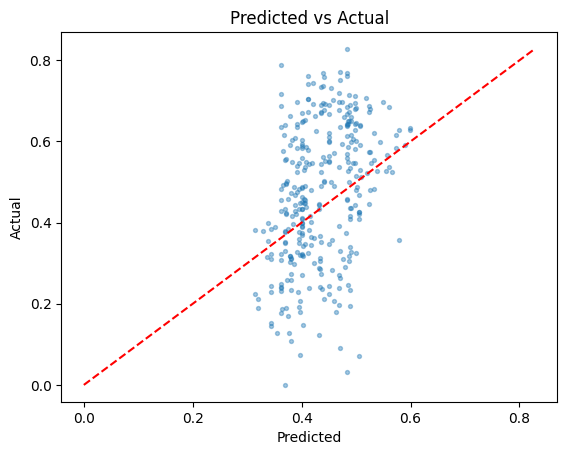

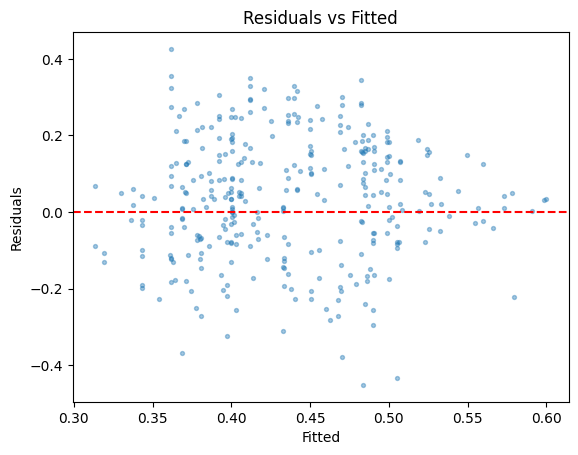

In [7]:
res = y_test - y_pred

# Predicted vs Actual
plt.scatter(y_pred, y_test, s=8, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Predicted vs Actual")
plt.show()

# Residuals vs Fitted
plt.scatter(y_pred, res, s=8, alpha=0.4)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Fitted"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()